In [1]:
import pandas as pd
import numpy as np
import sys, getopt


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import numpy as np
from PIL import Image, ImageOps
import scanpy as sc

# Download input demo data
wget -O 10X_ST_demo.tar.gz https://zenodo.org/record/5765589/files/10X_ST_demo.tar.gz?download=1

tar -zxvf 10X_ST_demo.tar.gz



In [3]:
# change directory to 10X_ST_demo which is just downloaded, if in current directory
os.chdir('./10X_ST_demo')
inputfile='inputfiles.txt'

In [4]:
samples = pd.read_csv(inputfile, header = None)[0]
samples

0    10X_demo_data_Breast_Cancer_Block_A_Section_1
1    10X_demo_data_Breast_Cancer_Block_A_Section_2
2                        10X_demo_data_Human_Heart
3                   10X_demo_data_Human_Lymph_Node
Name: 0, dtype: object

In [5]:
samples[0]

'10X_demo_data_Breast_Cancer_Block_A_Section_1'

In [6]:
# samples = samples[0:2]
# samples

In [7]:
def read_each(i):
    adata = sc.read_visium(i)
    adata.var_names_make_unique()
    # flip Y axis to show correctly in cellxgene VIP
    adata.obsm['spatial'][:,1] = -adata.obsm['spatial'][:,1]
    return(adata)

adatals = [read_each(i) for i in samples]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
import anndata

In [9]:
sampleIDs = samples.str.extract(r'10X_demo_data_(.*)')
sampleIDs = "V1_"+ sampleIDs
sampleIDs

,0
0,V1_Breast_Cancer_Block_A_Section_1
1,V1_Breast_Cancer_Block_A_Section_2
2,V1_Human_Heart
3,V1_Human_Lymph_Node


In [10]:
sampleIDs[0].astype("category")

0    V1_Breast_Cancer_Block_A_Section_1
1    V1_Breast_Cancer_Block_A_Section_2
2                        V1_Human_Heart
3                   V1_Human_Lymph_Node
Name: 0, dtype: category
Categories (4, object): [V1_Breast_Cancer_Block_A_Section_1, V1_Breast_Cancer_Block_A_Section_2, V1_Human_Heart, V1_Human_Lymph_Node]

In [11]:
adata_merge = sc.AnnData.concatenate(*adatals, batch_key='sample', join='outer', batch_categories= sampleIDs[0].astype("category"))

In [12]:
adata_merge.obs.head()

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1-V1_Breast_Cancer_Block_A_Section_1,1,50,102,V1_Breast_Cancer_Block_A_Section_1
AAACACCAATAACTGC-1-V1_Breast_Cancer_Block_A_Section_1,1,59,19,V1_Breast_Cancer_Block_A_Section_1
AAACAGAGCGACTCCT-1-V1_Breast_Cancer_Block_A_Section_1,1,14,94,V1_Breast_Cancer_Block_A_Section_1
AAACAGGGTCTATATT-1-V1_Breast_Cancer_Block_A_Section_1,1,47,13,V1_Breast_Cancer_Block_A_Section_1
AAACAGTGTTCCTGGG-1-V1_Breast_Cancer_Block_A_Section_1,1,73,43,V1_Breast_Cancer_Block_A_Section_1


In [13]:
list(adatals[3].uns["spatial"])[0]

'V1_Human_Lymph_Node'

In [14]:
for i in list(range(len(adatals))):
    print(i)
    # add back the spatial coordinates as separate embeddings
    adata_merge.obsm['X_spatial_'+list(adatals[i].uns["spatial"])[0]] = np.zeros(adata_merge.obsm['spatial'].shape)
    adata_merge.obsm['X_spatial_'+list(adatals[i].uns["spatial"])[0]][np.where(adata_merge.obs['sample']==list(adatals[i].uns["spatial"])[0])] = adatals[i].obsm['spatial']

adata_merge.uns['spatial'] = dict()
for i in list(range(len(adatals))):
    adata_merge.uns['spatial']["spatial_"+list(adatals[i].uns["spatial"])[0]] = adatals[i].uns['spatial'][list(adatals[i].uns["spatial"])[0]]


0
1
2
3


In [15]:
adata_merge.var_names.str.startswith("MT-").sum()

13

In [16]:
# QC metric
adata_merge.var["mt"] = adata_merge.var_names.str.startswith("MT-")

In [17]:
sc.pp.calculate_qc_metrics(adata_merge, qc_vars=["mt"], inplace=True)

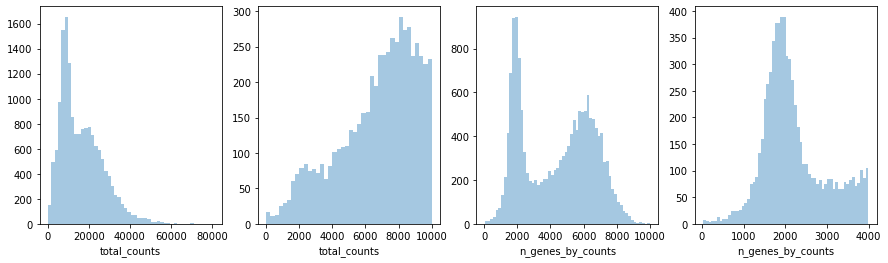

In [18]:
# QC plots
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata_merge.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata_merge.obs["total_counts"][adata_merge.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata_merge.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata_merge.obs["n_genes_by_counts"][adata_merge.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])


In [19]:
# filtering, turn this off to keep all spots for visualization also cutoffs are case-by-case based on the QC plots
#sc.pp.filter_cells(adata, min_counts=5000)
#sc.pp.filter_cells(adata, max_counts=35000)
#adata = adata[adata.obs["pct_counts_mt"] < 20]
#print(f"#cells after MT filter: {adata.n_obs}")
#sc.pp.filter_genes(adata, min_cells=10)


In [20]:
# normalization, log1p transformation and select HVGs
sc.pp.normalize_total(adata_merge, inplace=True)
sc.pp.log1p(adata_merge)
sc.pp.highly_variable_genes(adata_merge, flavor="seurat", n_top_genes=2000)


In [21]:
# PCA, UMAP and clustering by leiden
sc.pp.pca(adata_merge)
sc.pp.neighbors(adata_merge)
sc.tl.umap(adata_merge)
sc.tl.leiden(adata_merge, key_added="clusters")


In [22]:
# collect sample names
sampleNames = list()
for f in list(adata_merge.obsm):
    if "spatial_" in f: # search for the pattern
        library_id=f.replace("X_spatial_","") # parse the string and get the sample id
        #library_id=library_id.replace("V1_","")
        sampleNames.append(library_id)
sampleNames

['V1_Breast_Cancer_Block_A_Section_1',
 'V1_Breast_Cancer_Block_A_Section_2',
 'V1_Human_Heart',
 'V1_Human_Lymph_Node']

In [23]:
from PIL import Image
spatial=adata_merge.uns["spatial"]
dim=''
import math
if dim=='':
    height = math.ceil(math.sqrt(len(samples)))
    width = math.ceil(len(samples)/height)
else:
    width,height = dim.split('x')


In [24]:
print(height)
print(width)
print(len(sampleNames))

2
2
4


In [25]:
idx = 0
size=700
#creates a new empty image, RGB mode, and size 1400 by 1400.
new_im = Image.new('RGB', (size*width,size*height))
for i in range(0,size*width,size):
    for j in range(0,size*height,size):
        # load the image from the object
        #im = Image.fromarray((spatial["spatial_V1_"+samples[idx]]["images"]["lowres"]* 255).round().astype(np.uint8)) # found a solution to covert float32 to unit8
        im = Image.fromarray((spatial["spatial_"+sampleNames[idx]]["images"]["lowres"]* 255).round().astype(np.uint8)) # found a solution to covert float32 to unit8
        # paste images together
        new_im.paste(im, (j,i))
        print(idx)
        idx = idx+1
        if idx>=len(sampleNames):
            break


0
1
2
3


In [26]:
# fake a adata.uns by providing merged lowres image and scale factors 1
adata_merge.uns['spatial']['spatial_Merged'] = copy.deepcopy(adata_merge.uns['spatial'][list(adata_merge.uns['spatial'])[0]])
adata_merge.uns['spatial']['spatial_Merged']['images']["hires"] = np.asarray(new_im)
adata_merge.uns['spatial']['spatial_Merged']['images']["lowres"] = np.asarray(new_im)
adata_merge.uns['spatial']['spatial_Merged']['scalefactors']['tissue_lowres_scalef'] = 1
adata_merge.uns['spatial']['spatial_Merged']['scalefactors']['tissue_hires_scalef'] = 1

In [27]:
# add back the spatial coordinates as separate embeddings
idx = 0
adata_merge.obsm['X_spatial_Merged'] = adata_merge.obsm['spatial']
for i in range(0,size*width,size):
    for j in range(0,size*height,size):
        #library_id='spatial_V1_'+samples[idx] # parse the string and get the sample id
        library_id='spatial_'+sampleNames[idx] # parse the string and get the sample id
        print(library_id)
        tissue_lowres_scalef = spatial[library_id]['scalefactors']['tissue_lowres_scalef']
        adata_merge.obsm['X_spatial_Merged'][np.where(adata_merge.obs['sample']==sampleNames[idx])] = copy.deepcopy(adatals[idx].obsm['spatial'])
        adata_merge.obsm['X_spatial_Merged'][np.where(adata_merge.obs['sample']==sampleNames[idx]),1] = adatals[idx].obsm['spatial'][:,1]*tissue_lowres_scalef - i
        adata_merge.obsm['X_spatial_Merged'][np.where(adata_merge.obs['sample']==sampleNames[idx]),0] = adatals[idx].obsm['spatial'][:,0]*tissue_lowres_scalef + j
        idx = idx+1
        if idx>=len(sampleNames):
            break


spatial_V1_Breast_Cancer_Block_A_Section_1
spatial_V1_Breast_Cancer_Block_A_Section_2
spatial_V1_Human_Heart
spatial_V1_Human_Lymph_Node


In [28]:
outputfile = '10X_data.h5ad'
adata_merge.write_h5ad(outputfile)

... storing 'gene_ids-V1_Breast_Cancer_Block_A_Section_1' as categorical
... storing 'feature_types-V1_Breast_Cancer_Block_A_Section_1' as categorical
... storing 'genome-V1_Breast_Cancer_Block_A_Section_1' as categorical
... storing 'gene_ids-V1_Breast_Cancer_Block_A_Section_2' as categorical
... storing 'feature_types-V1_Breast_Cancer_Block_A_Section_2' as categorical
... storing 'genome-V1_Breast_Cancer_Block_A_Section_2' as categorical
... storing 'gene_ids-V1_Human_Heart' as categorical
... storing 'feature_types-V1_Human_Heart' as categorical
... storing 'genome-V1_Human_Heart' as categorical
... storing 'gene_ids-V1_Human_Lymph_Node' as categorical
... storing 'feature_types-V1_Human_Lymph_Node' as categorical
... storing 'genome-V1_Human_Lymph_Node' as categorical


In [29]:
adata_merge.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,clusters
AAACAAGTATCTCCCA-1-V1_Breast_Cancer_Block_A_Section_1,1,50,102,V1_Breast_Cancer_Block_A_Section_1,3893,8.267192,10073.0,9.217713,24.034548,32.691353,41.695622,54.631192,408.0,6.013715,4.050432,10
AAACACCAATAACTGC-1-V1_Breast_Cancer_Block_A_Section_1,1,59,19,V1_Breast_Cancer_Block_A_Section_1,8331,9.027859,47039.0,10.758754,19.728311,28.444482,37.894088,50.587810,1911.0,7.555905,4.062586,6
AAACAGAGCGACTCCT-1-V1_Breast_Cancer_Block_A_Section_1,1,14,94,V1_Breast_Cancer_Block_A_Section_1,1915,7.557995,3232.0,8.081165,19.399752,27.753713,37.778465,56.219059,76.0,4.343805,2.351485,1
AAACAGGGTCTATATT-1-V1_Breast_Cancer_Block_A_Section_1,1,47,13,V1_Breast_Cancer_Block_A_Section_1,5268,8.569596,19775.0,9.892224,35.322377,44.262958,52.176991,61.623262,473.0,6.161207,2.391909,10
AAACAGTGTTCCTGGG-1-V1_Breast_Cancer_Block_A_Section_1,1,73,43,V1_Breast_Cancer_Block_A_Section_1,8123,9.002578,45255.0,10.720091,20.139211,29.150370,39.533753,52.666004,1615.0,7.387709,3.568666,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1-V1_Human_Lymph_Node,1,58,42,V1_Human_Lymph_Node,5771,8.660774,19649.0,9.885833,27.131152,35.950939,44.429742,55.000254,209.0,5.347107,1.063667,2
TTGTTTCATTAGTCTA-1-V1_Human_Lymph_Node,1,60,30,V1_Human_Lymph_Node,6354,8.756997,21557.0,9.978502,24.238067,32.263302,40.265343,51.152758,208.0,5.342334,0.964884,2
TTGTTTCCATACAACT-1-V1_Human_Lymph_Node,1,45,27,V1_Human_Lymph_Node,6517,8.782323,22175.0,10.006766,21.506201,30.593010,39.098083,50.119504,192.0,5.262690,0.865840,2
TTGTTTGTATTACACG-1-V1_Human_Lymph_Node,1,73,41,V1_Human_Lymph_Node,4476,8.406708,12268.0,9.414831,24.078904,34.268014,43.193675,54.964134,121.0,4.804021,0.986306,9
